In [1]:
# using Pkg;Pkg.status()
using Statistics,LsqFit,Optim
using PyPlot,PyCall,Photodynamics,DelimitedFiles


## Optimizing
### 1/26/24
Curve fit only works with $\chi^2$ not student's t. so can't use existing code from Trappist-1 paper.
## Exomoons
How to add moons to existing Nbody Gradient code?Most massive body  (or binary )to left of next most massive.

Which would come first? moon around earth or [EMB around sun]

Can make lightcurve from Venus, Earth, and Moon transiting the sun.
### 8/24/24
You want to read the rows of the H matrix from top to bottom to work out the order of the orbital elements. t0 would be when moon transits earth [how to get this?]
$[SV 0 0;
0 0 EM;
SVB EMB;
-1 -1 -1 -1]$

To plot orbits, need parent indices; then transform positions to frame of parent (may not require parent positions), only works if we have a period for satellite.


## Cartesian initial conditions 
Take cartesian cordinates from JPL and compute light curve. 

### 9/17/24
Can't get orbital elements of V+ E because we don't have ϵ from Cartesian InitialConditions

In [4]:
# include("../src/sim_times.jl") 
# has regress.jl and the eph
jd1=2.4332825e6 ; sigma=30 ;jdsize=10;nyear=15
jd2 = nyear*365.25 + jd1
theta_sun=range(0, stop=2pi, length=100)
xsun = CGS.RSUN/CGS.AU * cos.(theta_sun)
ysun = CGS.RSUN/CGS.AU * sin.(theta_sun)
t0 = range(jd1,stop=jd2-1,length = jdsize)
nbody=3
pos= zeros(3, nbody,jdsize)
vel = zeros(3, nbody,jdsize)
for j=1:jdsize
bodyids=[10,2,399] # sun, venus, and earth
for i=1:nbody
pva=compute(eph,t0[j],0.0,bodyids[i],10,options)./AU
pos[:,i,j],vel[:,i,j] = pva[1:3],pva[4:6]
end
end
m=[1.0, 2.5422162292092204e-6, 3.0256056455411807e-6]

3-element Vector{Float64}:
 1.0
 2.5422162292092204e-6
 3.0256056455411807e-6

In [42]:
# color_list=["#fcfdbf","#feca8d","#fd9668","#f1605d",
#     "#cd4071","#9e2f7f","#721f81","#440f76","#180f3d","#000004"]

### SS parameters
#### From PlanetaryBodyData.pdf
- true $\lambda$ : [181.97973, 100.46435] degrees jup=34.40438 |
- true $\varpi$ : [131.53298, 102.94719] |
- inclination: [3.39471, 0.00005] degrees |
- eccentricity: [0.00677323, 0.01671022] 

#### Solar properties
- surface gravity -> $g= 274$ m/s2 ; https://nssdc.gsfc.nasa.gov/planetary/factsheet/sunfact.html 
- FEH -> $\log{\epsilon}_{Fe} = 7.46 \pm 0.04$ 
- limb dark coefficients -> $u1=0.39256$, $u2=0.29064$ https://arxiv.org/pdf/1403.3487.pdf 

In [3]:
# Make lighcurve with exomoon in Photodynamics
star=Elements(m=1.0, P=0.0  ,    
    t0=0.0   ,
    ecosω=0.0  ,  
    esinω=0.0  , 
    I=0.0   ,
    Ω=0.0)
p1=Elements(m=2.5422162292092204e-6,
   P=224.70078014619864,
  t0=3503.765349062694,
    ecosω=-0.003,
    esinω=-0.006,
    I=pi/2,
    Ω=0.0)
p2=Elements(m=3.0256056455411807e-6,
   P=365.2564540136157,
  t0=3624.4021734758985,
     ecosω=0.011,
     esinω=0.012,
        I=pi/2,
        Ω=0.0)
moon=Elements(m=0.012*(p2.m),P=27.3,t0=3624.3949611424468,
e=0.055,I=(pi/2)-deg2rad(5),Ω=deg2rad(60))
H=[-1 1 0 0;0 0 -1 1; -1 -1 1 1; -1 -1 -1 -1]

t0=3283.5;tmax=4000.0;h=0.05
ic=ElementsIC(t0,H,[star;p1;p2;moon])
intr=Integrator(h,t0,tmax)
s=State(ic);
rstar = 0.00465047 # Sol (Rstar/AU)
u_n = [0.39256, 0.29064];  # Quad. Limbdarkening coefficients 
k_moon = [0.0087002, 0.0091705, 0.27*0.0091705]  # Radius ratios with moon

cadence = 2 / 60 / 24  # 2 minute cadence in days
obs_duration = tmax-t0  # Duration of observations in days
tobs = collect(t0:cadence:t0+obs_duration) 
lc = Lightcurve(cadence, tobs, ones(length(tobs)), zeros(length(tobs)), u_n, k_moon, rstar); 
ts = TransitSeries(tmax,ic) ;# args: max time obs, IC, h [step size for series pnts]
tt = TransitTiming(tmax,ic) ;#TransitTiming(intr.tmax,ic) # ;need this for grad;
intr(s, ts, tt; grad=false);
compute_lightcurve!(lc, ts);

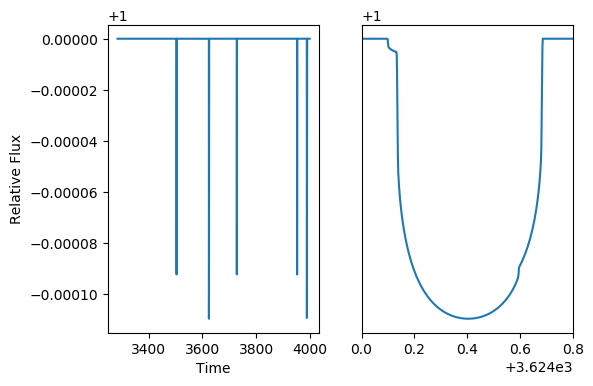

In [5]:
fig=figure(figsize=(6,4))
ax1,ax2=fig.subplots(1,2)
ax1.plot(lc.tobs,1 .+ lc.flux)
ax1.set_xlabel("Time");ax1.set_ylabel("Relative Flux")
ax2.plot(lc.tobs,1 .+ lc.flux)
ax2.set_xlim(3624.0,3624.8);ax2.tick_params(left=false,labelleft=false)

In [6]:
# """ to simulate transit times
# # data=[body,tt0,ttimes,sigtt]
# PLANET_INDX=data[1];TRANSIT_INDX=data[2];
# TT_OBS=data[3];SIG_TT=data[4];TCALC_LIN=data[5];
# """
include("../src/sim_times.jl") # has regress.jl
jd1=2.4332825e6 ; sigma=30 ; nyear=15
tref=2430000;  # value subtracted from times when fitting
obs="fromEV"
@time data=sim_obs_and_find_times(jd1,sigma,nyear,obs);
p=sortperm(data[3])
tt0=data[5][p] .-tref; nobs=length(tt0)
tt_data=zeros(nobs,4)
tt_data[:,4] .= data[4][p] ; tt_data[:,3] .= data[3][p].-tref
tt_data[:,2] .= data[2][p]; tt_data[:,1] .= data[1][p];

P1 linear coefficients: -16496.23076069122 , 224.7008069553705
P2 linear coefficients: -16375.590892987326 , 365.2564083425263
Peak amplitude
A_TTV1= 3.7153342366218567
A_TTV2= 6.308289393782616
  5.509337 seconds (5.45 M allocations: 311.599 MiB, 1.77% gc time, 99.76% compilation time)


### Try constructing a method to compute tt model, and fitting with LsqFit curve_fit
- needs F(t,$\theta$) where t is an array of independent variables and $\theta$ is an array of model parameters. 
- $\theta = [m_1, P_1,t_{0,1},e\cos\varpi,e\sin\varpi,........,k, u_n,r_\star]$; where $k$ vector has radius ratios, $u_n$ are limb dark coefficients


In [137]:
k = [0.0087002, 0.0091705]  # Radius ratios
pl_params=[2.5422162292092204e-6,  224.70078014619864, 3503.765349062694,  -0.003 , -0.006     
    ,3.0256056455411807e-6,  365.2564540136157, 3624.4021734758985, 0.011 , 0.012 ]
# , 0.3227e-6 ,   686.980      ,   383.823     ,     0.0403   ,    0.0268 
#     ,0.0007712378609020167, 4210.1287973187655, 603.9841005839645  ,0.0131 ,0.0925]#, π/2, π]
# ,2.8420e-4  ,	10755.5  ,	892.111  ,	-0.051  ,	0.014
θ=[pl_params;k;u_n;rstar;1.0] ;

In [259]:
module AgolModels
using Photodynamics
struct AbstractModel <: AbstractFloat end
mutable struct PhotometryModel{T<:Real} #<: AbstractModel
    θ::Vector{T}
    ic::ElementsIC{T}
    tt::TransitTiming{T}
    ts::TransitSeries{T,Photodynamics.ComputedTimes}
    d::NbodyGradient.Derivatives{T}
    lc::Lightcurve{T}
    intr::Integrator
    npar_per_pl::Int64
    N::Int64
    t0::T
    tmax::T
    h::T
    grad::Bool
#     J::Matrix{T}
end
# For fitting, define photodynamic model
function PhotometryModel(θ,nplanet,t0,tmax,h;vary_orb_angles::Bool=false) 
    if vary_orb_angles; npar_per_pl=7 ; else npar_per_pl=5 end
    N=nplanet+1
    @assert(length(θ)> npar_per_pl*nplanet)
    k = sqrt.(θ[npar_per_pl*nplanet+1:end-4]) #radius ratios
    u_n = (θ[end-3:end-2]) # quadratic limb dark. coeefs
    rstar = θ[end-1] 
    mstar = θ[end] # we ususally assume that were using mass-ratios, but just in case
    elements=zeros(nplanet+1,7)
#     if mstar==1.0 
#         continue
#     else
        elements[1,1]==1.0
#     end
#     elements[1,1]=mstar
    for i=1:nplanet 
        elements[i+1,1:5] .= θ[(i-1)*5 + 1:5*i]
        if vary_orb_angles #         if i<3 && nplanet >2
        elements[i+1,6:7] =  θ[(i-1)*5+6:(i-1)*5+7]
        else
        elements[i+1,6] = pi/2;    
        elements[i+1,7] = pi 
        end
    end
    lc = Lightcurve(h, tmax-t0, copy(u_n), copy(k), rstar);
    ic = ElementsIC(t0,N,elements)
    intr=Integrator(h,t0,tmax)
    tt = TransitTiming(intr.tmax, ic)
    ts = TransitSeries(intr.tmax, ic)
    d = NbodyGradient.Derivatives(Float64, ic.nbody);
    grad=false
 return PhotometryModel(θ,ic,tt,ts,d,lc,intr,npar_per_pl,N,t0,tmax,h,grad)
#     return PhotometryModel(θ,ic, tt, ts, d, lc, scaled_vars,nparam, nplanet,t0,tmax,h)
end
PhotometryModel(θ;nplanet,t0,tmax,h=0.05) = PhotometryModel(θ,nplanet,t0,tmax,h)

#     TODO: actual make this work
function compute_model(model::PhotometryModel;grad=false) where T<:Real
   θ=model.θ # where θ contains [pl_params;k;u_n;rstar]
    nplanet=model.N-1 ; npar_per_pl=model.npar_per_pl
    @assert(length(θ)> nplanet*npar_per_pl + 3)
    # Set up initial conditions: 
    model.ic.elements[1,1]=1.0 # ensure mass-ratios
    NbodyGradient.amatrix(model.ic)
    NbodyGradient.zero_out!(model.tt)
    NbodyGradient.zero_out!(model.d)
#     tt = TransitTiming(model.intr.tmax, model.ic)

#     setproperty!(model,:tt,ts)
    tt=model.tt;lc=model.lc;ts=model.ts
    tmax=model.tmax;t0=model.t0;h=model.h
    ic=model.ic
#     @show ic.elements
    s = State(ic) 
    intr=Integrator(h,t0,tmax) 
    # Compute the transit times from dynamical model
    intr(s,ts,tt;grad=grad)
    setproperty!(model,:tt,tt)
#     compute_lightcurve!(lc,ts)
    return model.tt
end
export PhotometryModel
end
using .AgolModels

In [260]:
model=AgolModels.PhotometryModel(θ,nplanet,t0,tmax,0.5);
# model.θ
# AgolModels.compute_model(model)


LoadError: type Nothing has no field θ

In [224]:
intr=model.intr
s=State(model.ic)
intr(s,model.ts,model.tt,grad=false)

8-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [139]:
#TO DO:  Need to implement fit of light curve
"""  
When parameterized as θ=[pl_params;k;u_n;rstar]
Need to change nparam and elements array if inc. and long of peri. are included:
"""
nplanet=2 ; nparam=5
# Rescale parameters to make them similar orders of magnitude: is this needed?
mfac = 1e6; eccfac=1e3
pfac = ones(nplanet,5); 
pfac[:,1] .= mfac; pfac[:,4:5] .= eccfac
# Compute the transit times given a set of orbital elements:
function compute_photometry(tobs,θ)
    t0=tobs[1] ; tmax=tobs[end]+1 ; 
    k = sqrt.(θ[nparam*nplanet+1:end-3]) #radius ratios
    u_n = (θ[end-2:end-1]) # quadratic limb dark. coeefs
    rstar = θ[end] 
    elements=zeros(nplanet+1,7)
    for i=1:nplanet
        elements[i+1,1:5] .= θ[(i-1)*5 + 1:5*i]
        elements[i+1,6] = pi/2;    
        elements[i+1,7] = pi   
    end
    ic=ElementsIC(t0,nplanet+1,elements);   s = State(ic)
    ic.elements[1] = 1.0 # Make sure we're using mass ratios
    lc = Lightcurve(cadence, tobs, ones(length(tobs)), 
        zeros(length(tobs)), copy(u_n), copy(k), rstar);
    intr = Integrator(0.05, tmax)
    ts = TransitSeries(tmax,ic);  tt = TransitTiming(tmax,ic) 
    intr(s, ts, tt; grad=false)
    compute_lightcurve!(lc, ts)
    return
end
function compute_jacobian_phot(tobs,θ) 
    t0=tobs[1] ; tmax=tobs[end]+0.05 ; 
    params0=reshape(θ[1:nplanet*nparam], 5, nplanet)'.*pfac
    elements=zeros(nplanet+1,7)
    for i=1:nplanet
        elements[i+1,1:5] .= θ[(i-1)*5 + 1:5*i]
        elements[i+1,6] = pi/2;    
        elements[i+1,7] = pi   
    end
    k = sqrt.(θ[nparam*nplanet+1:end-3]) #radius ratios
    u_n = (θ[end-2:end-1]) # quadratic limb dark. coedfs
    rstar = θ[end] 
    ic=ElementsIC(t0,nplanet+1,elements);  s = State(ic)
    ic.elements[1] = 1.0 # Make sure we're using mass ratios
    intr = Integrator(0.05, tmax)
    ts = TransitSeries(tmax,ic);  tt = TransitTiming(tmax,ic) 
    d = NbodyGradient.Derivatives(Float64, ic.nbody)
    intr(s, ts,tt, d; grad=true)
    J = zeros(nobs,5*nplanet)
    for itrans=1:nobs
        iparam=1  
        # Jacobian wrt mass-ratio:
    for iplanet=1:nplanet
        J[itrans,iparam] = tt.dtdelements[ip[itrans],jp[itrans],7,iplanet+1]/mfac
        iparam += 1
    end
        # Jacobian wrt period, t0, e*cos(omega), e*sin(omega):
    for k=1:4
      for iplanet=1:nplanet
        J[itrans,iparam] = tt.dtdelements[ip[itrans],jp[itrans],k,iplanet+1]/pfac[iplanet,k+1]
        iparam += 1 # Move to next varied parameter
      end
    end
    end
    return J
end

# θ_init = [ic.elements[2:end,1:5]'[:]..., k..., u_n..., rstar]
# ic_opt = deepcopy(ic)
# tt_opt = TransitTiming(obs_duration+1.0, ic_opt)
# ts_opt = TransitSeries(obs_duration+1.0, ic_opt)
# lc_opt = Lightcurve(cadence, copy(tobs), similar(tobs), copy(tobs), copy(u_n), copy(k), rstar);

In [55]:
function nbody_wrapper(t0,tmax,nplanet,θ::AbstractVector;init_model::Bool=false,jacobian::Bool=false,
        compute_lc::Bool=false,vary_orb_angles::Bool=false) where T<:Real
    if vary_orb_angles; nparam=7 ; else nparam=5 end
    # Set up initial conditions:
    N=nplanet+1
    elements=zeros(N,7);pl_param=zeros(length(θ))
    elements[1,1]=1.0
    if jacobian
    pl_param=vec(transpose(reshape(θ,nplanet,nparam))) # for factor scaling 
    else
    pl_param=copy(θ)
    end
    for i=1:nplanet
        elements[i+1,1:nparam] .= pl_param[(i-1)*nparam + 1:nparam*i]
        if vary_orb_angles # may be neccesary if only for some planets
        elements[i+1,6:7] =  pl_param[(i-1)*5+6:(i-1)*5+7]
        else
         elements[i+1,6] = π/2  
        elements[i+1,7] = π 
        end
    end
    cadence = 2 / 60 / 24  # 2 minute cadence in days
    obs_duration = tmax-t0  # Duration of observations in days
    tobs = collect(t0:cadence:t0+obs_duration) 
    ic = ElementsIC(t0, N, elements) 
    @show ic.elements
    # Initialize (current) state and data structures:
    intr = Integrator(0.05, tmax) # OR  intr=Integrator(h,t0,tmax)
    s = State(ic) 
    ts = TransitSeries(tmax,ic) # args: max time obs, IC, h [step size for series pnts]
    tt = TransitTiming(tmax,ic) 
#     NbodyGradient.amatrix(ic)
    # Compute the transit times from dynamical model:
    if jacobian; grad=true; else; grad=false; end
    intr(s, ts, tt; grad=grad)
    if init_model
        return tt
    elseif compute_lc # Compute the photometry: (only works if given radius ratios for all planets)
        @assert(length(θ)> nparam*nplanet + 3)
         # Set up light curve:
        k = sqrt.(θ[nparam*nplanet+1:end-3]) #radius ratios
        u_n = (θ[end-2:end-1]) # quadratic limb dark. coedfs
        rstar = θ[end] 
        lc = Lightcurve(cadence, tobs, ones(length(tobs)), zeros(length(tobs)), u_n, k, rstar)
        compute_lightcurve!(lc, ts)
        return lc
    else
    tts=[tt.tt[i,:][tt.tt[i,:] .!= 0.0] for i=2:N]
    return tts
    end
end
nbody_wrapper(t0,tmax,nplanet,θ;init_model::Bool,vary_orb_angles::Bool)=nbody_wrapper(t0,tmax,nplanet,θ;init_model,jacobian=false,
        compute_lc=false,vary_orb_angles)

nbody_wrapper (generic function with 2 methods)

In [138]:
# Testing:
t0=0.0;tmax=738.0;h=0.05;nplanet=2
# nbody_wrapper(t0,tmax,nplanet,θ_p3)

3

In [11]:
function chi_square(ttobs,model;sorted=true)
    ntransit=size(ttobs)[1]
    chisq=0.0
    if sorted
    for i=1:ntransit
        chisq+= ((ttobs[i,3] .- model[i])./ttobs[i,4])^2
    end
    else
    end
    return chisq
end
# Sort the data by the time & match obs transits to model transits
function match_transits(ttobs,elements,tt,count)
    ntransit=size(ttobs)[1]
	ip = zeros(Int64,ntransit); #     ip=Array{Int64}(undef, ntransit) # planet index
    jp = zeros(Int64,ntransit); #     jp=Array{Int64}(undef, ntransit) # transit index
	i = 1; ip0 = 0;
	tmod = zeros(Float64,ntransit); j = 1;
	while i <= ntransit
		  ip[i] = ttobs[i]+1 # add 1 bcuz first object is star in Nbodygradient
		  if ip[i] != ip0 # and it shouldn't
		    j=1
		    ip0 = ip[i]
		  end
		  tdiff = Inf
# When transit number < total transits observed & diff. is > 0.1 Period of planet i 
# Q. why? really large TTV signal always gonna be smaller than 1/10th of period
# if transits are in order, only need to compare to last observed transit
# maybe should be abs val of diff btween current observed time and all of the times 
#   BUT this assuems good initial guess close to correct value or good model fit
		  while j <= count[ip[i]] && tdiff > 0.1*elements[ip[i],2]
            # Find difference between model time and observed time for i planet:
			tdiff = abs(tt[ip[i],j] - ttobs[i,3])
		    j += 1
		  end
		  jp[i] = j-1
        if tdiff> 0.1*elements[ip[i],2]
            tmod[i]=-1
        else
		  tmod[i] = tt[ip[i],jp[i]]
        end
		  i += 1
        ip0=0
	end
	return tmod,ip,jp
end

match_transits (generic function with 1 method)

In [48]:
# nparam=7
# params0=reshape(θ_p3[1:(nplanet-1)*5], 5, nplanet-1)'
# part2= θ_p3[(nplanet-1)*5+1:(nplanet-1)*5+7]#,7,1)
# vec(params0)
(π/2)*1e2

157.07963267948966

In [53]:
function optimize_nbody(tt_data,θ,nplanet;vary_orb_angles::Bool=false)
# Provide times for integration and timestep h:
t0=3283.5;tmax=8738.0;h=0.05
# Initialize data structures to do computations in-place:
model=PhotMod.PhotometryModel(θ,nplanet,t0,tmax,h)
tt=nbody_wrapper(t0,tmax,nplanet,θ;init_model=true,vary_orb_angles=vary_orb_angles); 
model.ic.elements[1] = 1.0 # Make sure we're using mass ratios
# Get ingetration scheme:
N=model.ic.nbody ; intr=model.intr; nparam=model.nparam
# lc=model.lc;d=model.d; # tt=model.tt;ic=model.ic;ts=model.ts # model.tt=tt;model.ts=ts
# Save initial elements:
elements0=model.ic.elements
elements_new=copy(elements0)
# Get sorted indices for planets and transits:
tmod0,ip,jp=match_transits(tt_data,elements0,tt.tt,tt.count)
nobs=size(tt_data)[1]
s=State(model.ic)
"""
 Derivatives in jacobian matrix work best when the parameters are comparable.
"""
# Rescale parameters to make them similar orders of magnitude:
mfac = 1e6; eccfac=1e3 ; angfac=1e2
pfac = ones(nplanet,nparam); 
pfac[:,1] .= mfac; pfac[:,4:5] .= eccfac
if vary_orb_angles
     pfac[:,6:7] .== angfac
end
params0=reshape(θ[1:nplanet*nparam], nparam, nplanet)'.*pfac
function in_bounds(param)
    # Checks that eccentricity is inbounds [0, 1), masses are positive,
    p=param./pfac
    if !minimum(isfinite.(p))|| minimum(p[1:nplanet]) <= 0.0 || minimum(p[nplanet+1:nplanet+2]) <= 0.0 ||
    (maximum(p[1:nplanet]) > 1e-3*mfac)|| maximum(abs.(p[3*nplanet+1:nparam*nplanet])) > .9*eccfac # arbitrary limit for ecc.
        return false
    end
    return true
end
# Compute transit times for initial conds (with grad=false); returns sorted times:
function compute_model(tephem::Vector{T},param) where T<:Real
#   Put parameters back into elements matrix:
    elements_new[2:N,1:nparam].=reshape(param./vec(pfac),nplanet,nparam)
    model.ic =ElementsIC(t0,N,elements_new)
# Initialize the state and the data structures:
    s=State(model.ic)
    NbodyGradient.amatrix(model.ic)
    NbodyGradient.zero_out!(model.tt)
    NbodyGradient.zero_out!(model.d)
    model.ts.count .= 0     
    intr(s,model.ts,model.tt,grad=false)
    tmod_new=Array{Float64}(undef, nobs)
    itrans=1
    while itrans<=nobs
        tmod_new[itrans]=model.tt.tt[ip[itrans],jp[itrans]] 
        itrans+=1
    end
    return tmod_new
end
# Compute Jacobian of transit times wrt model parameters:
function compute_jacobian(tephem::Vector{T},param) where T<:Real
    elements_new[2:N,1:nparam].=reshape(param./vec(pfac),nplanet,nparam)
    model.ic=ElementsIC(t0,N,elements_new)
    s=State(model.ic) 
    NbodyGradient.amatrix(model.ic)
    NbodyGradient.zero_out!(model.tt)
    NbodyGradient.zero_out!(model.d)
    # Run integrator w/ derivative structure:
    intr(s,model.tt,model.d,grad=true) 
    J = zeros(nobs,nparam*nplanet)
    # Place timing derivatives into Jacobian matrix. 
        #Q?Derivative matrix has mass last:
    for itrans=1:nobs
        iparam=1  # This is the index in param0/p of all parameters
    # Jacobian wrt mass-ratio:
        for iplanet=1:nplanet      
            J[itrans,iparam] = model.tt.dtdelements[ip[itrans],jp[itrans],7,iplanet+1]/mfac
            iparam += 1
        end
    # Jacobian wrt period, t0, e*cos(omega), e*sin(omega):
        for k=1:nparam-1 # 1:4 if nparam=5 
          for iplanet=1:nplanet
            iparam = k*nplanet+iplanet  # This is the index in param0 of all parameters
            J[itrans,iparam] = model.tt.dtdelements[ip[itrans],jp[itrans],k,iplanet+1]/pfac[iplanet,k+1]
            iparam += 1 # Move to next varied parameter
          end
        end
    end
    return J
end
if !in_bounds(params0)
    println("Not in bounds.") 
end
chisq0=chi_square(tt_data,tmod0)
println("Initial chisq=",chisq0)
chi=0.0 ; telapse = 0.0
weight = ones(nobs) ./ tt_data[:,4].^2 ; tt0=tt_data[:,2]
# Convert initial params to vector to perform LM with LsqFit:
par_vec=vec(params0)
tstart=time()
fit = curve_fit(compute_model, compute_jacobian, tt0,  tt_data[:,3], weight,par_vec)
# Curve fit with anonymous function:
chisq=chi+10 ; par_tmp=par_vec .+ 10
tol=1e-5;niter=0; itmax=5
# while niter < itmax #&& (chisq - chi) > 10 #maximum(abs.(par_tmp .- par_vec)) > tol
    #chi=chisq
# fit = curve_fit((tt0,pbest) -> compute_model(tt0,pbest),
#         compute_jacobian,tt0,tt_data[:,3],weight,par_vec)
results=reshape(fit.param./vec(pfac),nplanet,nparam)
@show results
# Replace original params for planets with fitted values:
elements_new[2:nplanet+1,1:nparam] = results
# Compute model for best fit results and match:
tt=nbody_wrapper(t0,tmax,nplanet,vec(results'),init_model=true);
ttmod,ip,jp=match_transits(tt_data,elements_new,tt.tt,tt.count)
chisq=chi_square(tt_data,ttmod)
@show chisq
#     niter+=1
# end
telapsed=time()-tstart

#     return res,chi
end

optimize_nbody (generic function with 1 method)

In [56]:
nplanet=3
@time fit=optimize_nbody(tt_data,θ_p3,nplanet) 

ic.elements = [1.0 0.0 0.0 0.0 0.0 0.0 0.0; 2.5422162292092204e-6 224.70078014619864 3503.765349062694 -0.003 -0.006 1.5707963267948966 3.141592653589793; 3.0256056455411807e-6 365.2564540136157 3624.4021734758985 0.011 0.012 1.5707963267948966 3.141592653589793; 0.0007712378609020167 4210.1287973187655 603.9841005839645 0.0131 0.0925 1.5707963267948966 3.141592653589793]
Initial chisq=391136.9084168282


LoadError: InterruptException:

In [57]:
t0=3283.5;tmax=8738.0;h=0.05;nplanet=2
tt1=tt_data[:,3][tt_data[:,1].==1.0]
tt2=tt_data[:,3][tt_data[:,1].==2.0]
nt1=length(tt1) ;nt2=length(tt2)
# When I optimized np=2:
results = [2.159432243459399e-6 224.70140121235525 3503.7696751819776 -0.06827275721786147 0.291493633402078
    ; 1.8421362762919043e-6 365.2581254489142 3624.409987660895 -0.05076597578243387 0.22822913404368003]
tt=nbody_wrapper(t0,tmax,nplanet,vec(results'),init_model=true);
tmod,ip,jp=match_transits(tt_data,ic.elements,tt.tt,[0 nt1 nt2])

# t01_fit=collect(results[1,3] .+ results[1,2] .*range(1,length=nt1,stop=nt1+1))
# t02_fit=collect(results[2,3] .+ results[2,2] .*range(1,length=nt2,stop=nt2+1))

ic.elements = [1.0 0.0 0.0 0.0 0.0 0.0 0.0; 2.159432243459399e-6 224.70140121235525 3503.7696751819776 -0.06827275721786147 0.291493633402078 1.5707963267948966 3.141592653589793; 1.8421362762919043e-6 365.2581254489142 3624.409987660895 -0.05076597578243387 0.22822913404368003 1.5707963267948966 3.141592653589793]


15-element Vector{Float64}:
 3989.668113109809
 4381.016104662217
 4772.3640962146255
 5163.712087767033
 5555.060079319442
 5946.408070871849
 6337.756062424258
 6729.104053976665
 7120.452045529074
 7511.800037081482
 7903.14802863389
 8294.496020186298
 8685.844011738705
 9077.192003291113
 9468.539994843522

In [110]:
# t01_fit
# tmod.-tt0
ttmod1=tmod[ip.==2]
ttmod2=tmod[ip.==3]
x1,t01,p1=linear_fit(ttmod1,results[1,2],ones(nt1).*0.0000374)
t01_fit=collect(t01 .+ p1 .* range(0,length=nt1,stop=nt1-1))
x2,t02,p2=linear_fit(ttmod2,results[2,2],ones(nt2).*0.0000374)
t02_fit=collect(t02 .+ p2 .* range(0,length=nt2,stop=nt2-1))

15-element Vector{Float64}:
 3624.4091070092522
 3989.6655153516936
 4354.921923694135
 4720.178332036577
 5085.434740379018
 5450.691148721459
 5815.947557063901
 6181.203965406342
 6546.460373748783
 6911.716782091225
 7276.973190433666
 7642.229598776107
 8007.4860071185485
 8372.74241546099
 8737.998823803431

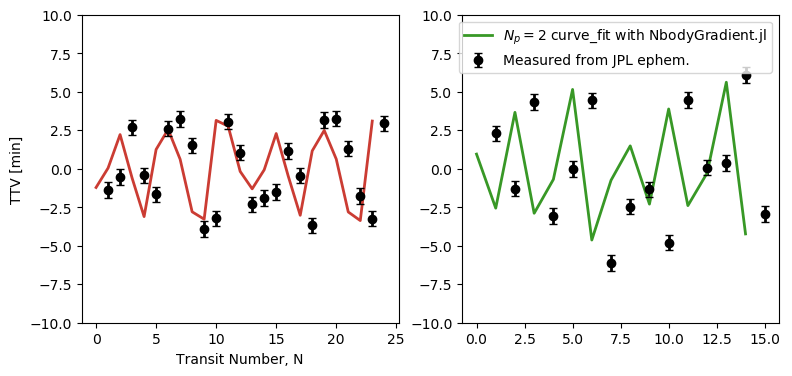

PyObject <matplotlib.legend.Legend object at 0x7f8bee631dd8>

In [134]:
julia_colors=["#000000","#389826","#CB3C33","#9558B2","#4063D8"]
fig=figure(figsize=(9,4))
ax=fig.subplots(1,2)
ax[1].plot((ttmod1.-t01_fit).*24*60,
    label=L"$N_p=2$ curve_fit with NbodyGradient.jl",color=julia_colors[3])
ax[1].errorbar(1:nt1,(tt1.-t01_fit).*24*60,tt_data[1:nt1,4].*24*60,fmt="o",capsize=3,
    label="Measured from JPL ephem.",color=julia_colors[1])
ax[2].plot((ttmod2.-t02_fit).*24*60,
    label=L"$N_p=2$ curve_fit with NbodyGradient.jl",color=julia_colors[2])
ax[2].errorbar(1:nt2,(tt2.-t02_fit).*24*60,tt_data[1:nt2,4].*24*60,fmt="o",capsize=3,
    label="Measured from JPL ephem.",color=julia_colors[1])
ax[1].set_xlabel("Transit Number, N");ax[1].set_ylabel("TTV [min]")
ax[2].set_ylim(-10,10);ax[1].set_ylim(-10,10)
legend()
# plot(tt_data.-tt0)

In [44]:
test2,chi2=optimize_nbody(tt_data,p3_param,3) # old bad

ic.elements[2:N, 1:5] .* pfac = [2.5422162292092203 224.70078014619864 3503.765349062694 -2.634290692237901 7.069884666418407; 3.0256056455411806 365.2564540136157 3624.4021734758985 12.05927363902475 8.297107290864002; 771.2378609020167 4210.1287973187655 603.9841005839645 16.165451882874706 -42.491363498421855]
Initial chisq=9.68504054609444e6
new_params = [3.6185640052991167e-6, 2.5166827505111597e-6, 5.740117235355872e-5, 224.7017187010129, 365.25583706377137, 4034.519314338262, 3503.7695024136333, 3624.409858674854, 785.8077923692747, -0.056563071777838474, -0.043205875492452375, -0.10663124685468599, 0.06711415011694322, 0.040985007428289054, 0.5717180999555397]
New chi=-3.8960609127763135e11


(LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([3.618564005299117, 2.5166827505111597, 57.40117235355872, 224.7017187010129, 365.25583706377137, 4034.519314338262, 3503.7695024136333, 3624.409858674854, 785.8077923692747, -56.56307177783847, -43.20587549245238, -106.63124685468598, 67.11415011694322, 40.98500742828905, 571.7180999555396], [0.3806373497354798, 1.9407205771130975, 0.7587248302297667, 0.4537244205130264, 1.8292542621202301, 1.0398411666392349, -1.4033313427353278, -1.89893058326561, -1.215242292091716, -0.04250758560374379  …  1.1598144244635478, 0.14792952686548233, -0.18001134507358074, -1.6203898983076215, -1.9477989489678293, -1.3522569020278752, -0.09239971695933491, 2.921336775762029, -0.014430148294195533, 0.013684902805835009], [-0.0006104737305770997 -1.8694492202727493 … -0.14821547497941237 0.01860958711970469; 1.810696107478649 0.0022984244371225863 … 0.43539244525291 

In [28]:
# best.param./vec(pfac

10-element Vector{Float64}:
    2.614148198323461e-6
    3.1311506469759116e-6
  224.7035596050799
  365.2534796866889
 3503.7670082863037
 3624.399731143171
    0.010567478645214083
    0.009219826271962172
   -0.04858687891641594
   -0.05107455631479781

In [90]:
# tmod_new=compute_model(tt_data[:,3],params0);
# J=compute_jacobian(tt_data[:,3],params0);
telapse = 0.0;     tstart = time()
weight = ones(nobs) ./ tt_data[:,4].^2 
#     new_param=params0.+100.0 ; 
tol=1e-5;niter=0; itmax=20
chi=0.0
while niter < itmax
res = curve_fit((tt0,pbest) -> compute_model(tt0,pbest),compute_jacobian,tt0,tt_data[:,3],weight,params0)
#         chi=chi_square(tt_data,(compute_model(tt0,params1./vec(pfac))))
#         println("New chi=",chi)
# niter+=1
end
# telapse = time()-tstart
# #     @time fit=curve_fit(compute_model, compute_jacobian,tt0,tt_data[:,3],weight,params0)
#     return pbest
# end

LoadError: UndefVarError: compute_jacobian not defined

In [30]:
# tmod_new=compute_model(tt0,
nt1=48;nt2=30
p1_data=[data[i][1:nt1] for i=1:5]
p2_data=[data[i][nt1+1:nt1+nt2] for i=1:5]
tts=nbody_wrapper(2,best.param./vec(pfac),jacobian=true);
# ttv_analytic=TTVFaster.ttv_wrapper(tt0,2,[nt1,nt2],param,5)
# ttmodel=[tts[1];tts[2]]
# time1=collect( res.param[5]./pfac[5] .+ range(0.0,stop=nt1+1,length=nt1).*res.param[3]./pfac[3]);
# time2=collect( res.param[6]./pfac[6] .+ range(0.0,stop=nt2+1,length=nt2).*res.param[4]./pfac[4]);
# fitmc=jldopen("../ttv_ss/FITS/fromEMB/p2_fit30s30yrs.jld2","r")

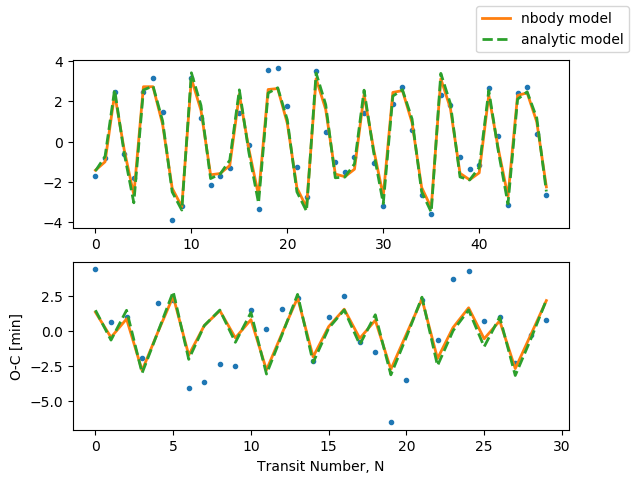

PyObject Text(0.5, 24.0, 'Transit Number, N')

In [231]:
fig=figure()
ax2=subplot(211)
ax2.plot((p1_data[3].-p1_data[5]).*24*60,".")
ax2.plot((tts[1].-(p1_data[5].-tref)).*24*60)
ax2.plot((ttv_analytic[1:nt1].-(p1_data[5].-tref)).*24*60,linestyle="--")

ax1=subplot(212)
ax1.plot((p2_data[3].-p2_data[5]).*24*60,".")
ax1.plot((tts[2].-(p2_data[5].-tref)).*24*60,label="nbody model")
ax1.plot((ttv_analytic[nt1+1:nt1+nt2].-(p2_data[5].-tref)).*24*60,label="analytic model",linestyle="--")
fig.legend()
ax1.set_ylabel("O-C [min]")
ax1.set_xlabel("Transit Number, N")

Since TTVFaster and NbodyGradient use different definitions of period, the linear ephemerides won't agree. I use the ephem found from JPLEphemerides in creating the TTV plots. This differes from the current method, in which I calculate new linear times based on the best-fit TTVFaster parameters for period and t0.

In [89]:
init_params=[2.65e-6,
  224.700,
 3503.761869180093,
   -0.01,
    0.01,
    3.03e-6,
  365.25,
 3624.4081674077343,
   -0.01,
    0.01]
# fit = curve_fit(model, xdata=tt0, ydata=tt, p0=init_params)# input = tt0, output=params
# fit = curve_fit((input,output) -> model_to_fit, xdata=tt0, ydata=tt, p0=init_params)
# weight = ones(78)./ sigtt.^2 
fit=curve_fit((tt0,pbest) -> nbody_wrapper(tt0,pbest),(tt0.-tref)[p],tmod,weight,init_params)

LoadError: UndefVarError: tmod not defined

In [418]:
#   sigtt=[sigtt1;sigtt2] 
using TTVFaster

weight = ones(nt1+nt2)./ sigtt.^2 
tt=[tt1; tt2]
tt0=[t01; t02]
fit0 = curve_fit((tt0,params) -> TTVFaster.ttv_wrapper(tt0,nplanet,[48; 30],params,5,true),tt0,tt,weight,pbest_logP)
fit.resid

10-element Vector{Float64}:
  1.7501633451833777e-8
 -3.2844738484527625e-7
  1.823673301259987e-6
 -0.038619774525784245
  0.0003459732204765791
 -4.7803811464698526e-8
 -9.176164269319997e-6
  7.051033799143624e-5
 -0.02980058525944671
  0.0010147872237117796

In [8]:
# read in obs transit times and expected trans times
nt1,nt2=p2_fit["ntrans"]

tt1=p2_fit["tt"][1:nt1]                 #tobs
tt2=p2_fit["tt"][nt1+1:nt1+nt2]

sig_tt1=p2_fit["sigtt"][1:nt1]          #tobs_err
sig_tt2=p2_fit["sigtt"][nt1+1:nt1+nt2];

tt01=p2_fit["tt0"][1:nt1]               #tcalc_linear
tt02=p2_fit["tt0"][nt1+1:nt1+nt2]

mu1,P1,t01,ecos1,esin1=pbest_logP[1:5]
mu2,P2,t02,ecos2,esin2=pbest_logP[6:10] #tcalc_best
time1=collect(t01 .+range(0,stop=nt1-1,length=nt1) .* P1)  
time2=collect(t02 .+range(0,stop=nt2-1,length=nt2) .* P2);

linear fit biases slope and mean value. TTVFaster takes mean orbital elments (oscullating). Nbody gradient takes instantaneous. 

In [201]:
tt_nb1=tt.tt[2,:][tt.tt[2,:] .!= 0.0]
tt_nb2=tt.tt[3,:][tt.tt[3,:] .!= 0.0]
tt_nb=[tt_nb1 ; tt_nb2];

println("starting time for planet 1:",'\n',"from NBodyGrad: ",tt_nb1[1]," from TTVFaster: ",tt1[1])
println("starting time for planet 2:",'\n',"from NBodyGrad: ",tt_nb2[1]," from TTVFaster: ",tt2[1])
println("ending time for planet 1:",'\n',"from NBodyGrad: ",tt_nb1[end]," from TTVFaster: ",tt1[end])
println("ending time for planet 2:",'\n',"from NBodyGrad: ",tt_nb2[end]," from TTVFaster: ",tt2[end])
println(length(tt_nb)," ",length([tt1;tt2]))

starting time for planet 1:
from NBodyGrad: 3503.7615927486763 from TTVFaster: 3503.7653924068436
starting time for planet 2:
from NBodyGrad: 3624.4085177634483 from TTVFaster: 3624.4024799037725
ending time for planet 1:
from NBodyGrad: 14064.536181864245 from TTVFaster: 14064.702071556356
ending time for planet 2:
from NBodyGrad: 14216.960845412255 from TTVFaster: 14216.839391200338
78 78


- 12/18/23 : Somehow, routine with TTVFaster skips the transit for Venus (at t=14513.936223576813).
- 1/09/24 : Added break to while loop. Now stopping before t0[end]. pre-2024 runs dont have this constraint

In [ ]:
# CartesianIC(positions,velocities, masses, nbody)
# anonymous function that optimizes initial conditions, given transit times from NbodyGrad
# curve_fit((ic)-> TransitTiming(intr.tmax,ic),init_params)

In [ ]:
# using Optim
# optimize(compute_photometry(θ,photodynamical_model),zeros(length(f)))
include("../toi-700/occultquad.jl")
u1=0.1;u2=0.1;p=0.05;z=0.0
init_params=[z,u1,u2,p]
model=occultquad(init_params)


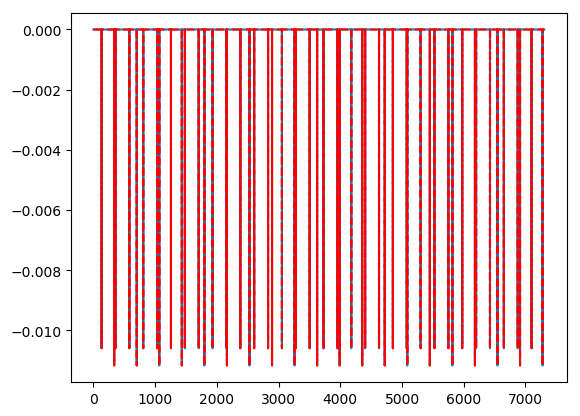

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa59a04b7b8>

In [71]:
plot(photodynamical_model.lc.tobs,photodynamical_model.lc.flux)
plot(photodynamical_model.lc.tobs,f,color="red",linestyle="--")

In [12]:
using HDF5
# h5write("/tmp/test2.h5", "test/lc", lc)
# lc.tobs,lc.flux
h5open("../ttv_ss/test/photodynamics_model.h5", "w") do file
    g = create_group(file, "lc") # create a group
    g["flux"] = lc.flux
    g["tobs"]= lc.tobs
    g["count"]=tt.count
    g["tt1"]=tt.tt[2,:]
    g["tt2"]=tt.tt[3,:]
    g["dt"]=lc.dt
    g["fobs"]=lc.fobs
    g["u_n"]=lc.u_n
    g["rstar"]=lc.rstar
    g["elements"]=ic.elements
    attributes(g)["Description"] = "This group contains flux (normed to 0), tobs , dt, fobs,u_n, rstar, initial conditions (i.e. elements)." # an attribute
end

"This group contains flux (normed to 0), tobs , dt, fobs,u_n, rstar, initial conditions (i.e. elements)."

In [ ]:
# Radius ratio:
r = 0.025717
# Ratio of semi-major axis to stellar radius:
aonr = 19.94
# Orbital period [d]:
period = 4.28746668
# Impact parameter:
b0 = 0.374
# Transit duration [hr] (this is time between first and fourth contact):
T = 1.5693

# Check that these agree.  Compute velocity:
v = 2*pi*aonr/period
# Transit duration [convert to hr], approximate:
T0 = 2*sqrt((1+r)^2-b0^2)/v*24

In [152]:
c = h5open("/tmp/test.h5", "r") do file
    read(file)
end

Dict{String, Any} with 1 entry:
  "lc" => Dict{String, Any}("fobs"=>[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.…

In [153]:
# lc.dt
# c["lc"]["tobs"]
# ic.elements

5259601-element Vector{Float64}:
    0.0
    0.001388888888888889
    0.002777777777777778
    0.004166666666666667
    0.005555555555555556
    0.006944444444444444
    0.008333333333333333
    0.009722222222222222
    0.011111111111111112
    0.0125
    0.013888888888888888
    0.015277777777777777
    0.016666666666666666
    ⋮
 7304.984722222222
 7304.986111111111
 7304.9875
 7304.988888888889
 7304.990277777778
 7304.991666666667
 7304.993055555556
 7304.9944444444445
 7304.995833333333
 7304.997222222222
 7304.998611111111
 7305.0

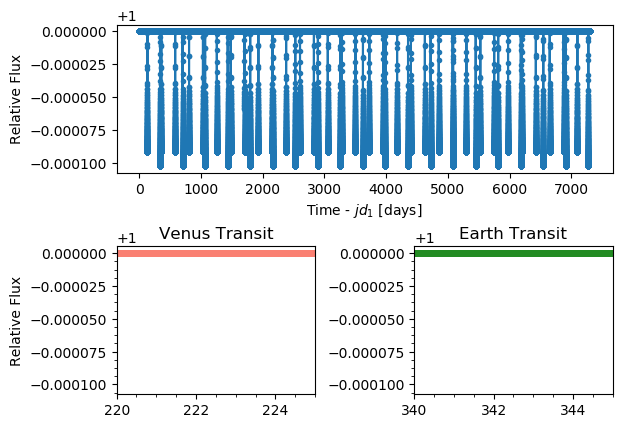

(340, 345)

In [13]:
using PyPlot
fig,ax=subplots()#,dpi=150)
subplots_adjust(hspace=0.5,wspace=0.5)
subplot(211)
plot(lc.tobs,lc.flux .+1,marker=".")
xlabel(L"Time - $jd_1$ [days]")
ylabel("Relative Flux")
subplot(223,title="Venus Transit")
plot(lc.tobs,lc.flux .+1,marker=".",color="salmon")
# xlabel("Time [days]")
ylabel("Relative Flux")
minorticks_on()
xlim(100,2)
subplot(224,title="Earth Transit")
plot(lc.tobs,lc.flux .+1,marker=".",color="forestgreen")
minorticks_on()
# xlim(340,345)
# plt.show()

For V+E, dynamic transit times occur before JPL mathematical transit times. Effect of moon? Likely increase accuracy of nbody 
Differences between "observed" transit times from JPL and dynamic transit times from NBoddy gradient range 
Is there a difference in reference angle? (can't remember how to compute)

In [50]:
RV_semiamplitude(4332.82,CGS.MJUPITER/1e3,0.048,1.305,CGS.MSUN/1e3)

15.181784137362147

In [145]:
a = Elements(m = 0.82)
b = Elements(
        m = 3.18e-4,
        P = 221.717,
        ecosω = 0.0069,
        I = pi/2,
)
c = Elements(
        m = 3e-6,
        P = 228.774,
        t0 = -228.774/6, # < We want mean anomaly to be +60 deg, so its
        ecosω  = 0.0054, #   transit should have about occurred 1/6 of an orbit 
        I = pi/2         #   prior to the initial time.
)

# Set up the integrator.
t0 = 7257.93115525  # Initialize IC, must be before first transit
h = 0.5       # Time step
tmax = 9837.282 # Time to integrate to.
# Generate the initial conditions
# ic = ElementsIC(t0,8,"T1_elements.txt")
test = ElementsIC(0.0,3,a,b,c)

# s = State(ic)
# intr = Integrator(h, 0.0, tmax)
# tt = TransitTiming(tmax,ic); #allocate arrays to hold transit times and derivatives
# # Now, run the integrator!
# intr(s,tt) # pass a TransitTiming structure to the integrator

# # plot the transit timing variations
# t1 = tt.tt[2,1:tt.count[2]]
# nplot = [8,22,43]
# for iplot=1:3
#   pavg = mean(t1[2:nplot[iplot]] - t1[1:nplot[iplot]-1])
#   it = collect(0:1:nplot[iplot]-1)
#   ttv1 = t1[1:nplot[iplot]] .- it .* pavg .- t1[1]
#   if iplot == 2
#     scatter(it,ttv1)
#   else
#     plot(it,ttv1)
#   end
#   println(pavg)
# end
@show test.ϵ
get_parent(test)


test.ϵ = [-1.0 1.0 0.0; -1.0 -1.0 1.0; -1.0 -1.0 -1.0]


3-element Vector{Any}:
 2
 2
 3

Results above match NbodyGradient TTV example. https://github.com/ericagol/NbodyGradient.jl/blob/master/examples/ttv_example.ipynb

In [ ]:
# using JLD2
#     p3=jldopen("../FITS/fromEMB/widep3_fit30s15yrs.jld2","r")
# par_p3=p3["param_p3"]
# lprob_p3=p3["lprob_p3"]
# plt.style.use("light_background")
# mu3= range(log10(1e-8), stop=log10(1e-2),length=10)
# fig=figure(figsize=(10,4))
# ax=fig.subplots(1,2)
# ax[1].set_xlabel("Orbital Period [days]",fontsize="x-large")
# ax[2].set_xlabel("Orbital Period [days]",fontsize="x-large")
# ax[1].set_ylabel(L"$\log$Prob",fontsize="x-large")
# for i=1:10
#     if i%2==0; ls="--"
#         else 
#         ls="-" ;end
#     ax[2].plot(par_p3[12,:,i],lprob_p3[:,i],"--",lw=2,
#     linestyle=ls)#color=color_list[i])
#     ax[1].plot(par_p3[12,:,i],lprob_p3[:,i],"--",lw=2,label=round(mu3[i],sigdigits=3),
#     linestyle=ls)#color=color_list[i],mew="white")
# end
# ax[2].set_ylim(-90,-64)
# ax[2].axvline(4333,linestyle="-.",color="black")
# ax[2].axvline(688,linestyle="-.",color="black")
# ax[2].text(4333*1.015,-70,s="Jupiter")
# ax[1].text(4000,-250,s=L"$μ=10^γ$ (i.e. mass-ratio)",fontsize="large")
# ax[2].text(688*1.1,-70,s="Mars",color="black")
# ax[1].legend(title=L"$γ$ values",fontsize="medium",ncol=2)
# fig.tight_layout()
# savefig("../IMAGES/planet4_trial.png",dpi=150)

In [11]:
using DataFrames,CSV

In [51]:
"""
---     KOI-S   Kepler Object of Interest number of star
                 (KOI -NNNN in Simbad)
---     KIC     [1718189/12314973] Kepler Input Catalog number
                 of star (KIC NNNNNNNN in Simbad)
---     KOI-P   Kepler Object of Interest number of planet
                 (KOI -NNNN.NN in Simbad)
---     Kepler  Kepler name of planet, if named (Kepler -NNNNAa
                 in Simbad)
Msun    M*      [0.624/1.4332] Stellar mass
Msun    R*      [0.614/3.36] Stellar radius
---     CDPP    [9.986/384.892] The 6-hour Combined Differential
                   Photometric Precision (CDPP_6hr_)
---     b       [0.0004/0.8999] Impact parameter
d       Per     Orbital period
Rgeo    Rp      Planet radius
Rgeo  e_Rp      Uncertainty in Rp
K       Teq     Equilibrium temperature
Rgeo    RpAvg   [0/11.3289969329] Average planet radius (1)
---     Pj+1/Pj [0/81.7781148492] Orbital period ratio
                  P_j+1_/P_j_ (1)
---     Delta   [0/82.8903285681] Mutual Hill radius {Delta}_RH_
                                 (1)
--------------------------------------------------------------------------------
Note (1): Of this planet and interior planet.
"""
CKS_names=["KOI-S","KIC","KOI-P","Kepler","Mstar","Rstar","CDPP","b","Per","Rp","e_Rp","Teq","RpAvg","Pj+1/Pj","Delta"]
CKS=readdlm("data/CKS.dat")
CKS_raw=DataFrame(CKS,CKS_names)
CKS_data=identity.(CKS_raw)

Row,KOI-S,KIC,KOI-P,Kepler,Mstar,Rstar,CDPP,b,Per,Rp,e_Rp,Teq,RpAvg,Pj+1/Pj,Delta
,SubStrin…,Int64,SubStrin…,Any,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,K00041,6521045,K00041.02,Kepler-100 b,1.107,1.55,23.331,0.5134,6.88706,1.35499,0.235962,1186.84,0.0,0.0,0.0
2,K00041,6521045,K00041.03,Kepler-100 d,1.107,1.55,23.331,0.5942,35.3331,1.54031,0.318251,687.853,1.95734,2.75698,31.2311
3,K00041,6521045,K00041.01,Kepler-100 c,1.107,1.55,23.331,0.5891,12.8159,2.37437,0.344682,965.148,1.86468,1.86086,20.1539
4,K00046,10905239,K00046.02,Kepler-101 c,1.156,1.58,54.612,0.4143,6.0298,1.18082,0.165451,1203.27,3.43956,1.72888,12.918
5,K00046,10905239,K00046.01,Kepler-101 b,1.156,1.58,54.612,0.0356,3.48769,5.6983,0.73868,1443.88,0.0,0.0,0.0
6,K00070,6850504,K00070.05,Kepler-20 f,0.934,0.949,39.416,0.3268,19.5776,1.01612,0.0870208,634.732,2.05855,1.80371,18.3685
7,K00070,6850504,K00070.03,Kepler-20 d,0.934,0.949,39.416,0.1206,77.6116,2.68703,0.219742,401.065,1.85157,3.9643,42.2023
8,K00070,6850504,K00070.01,Kepler-20 c,0.934,0.949,39.416,0.4384,10.8541,3.10099,0.277416,772.508,1.97241,1.77979,18.3415
9,K00070,6850504,K00070.02,Kepler-20 b,0.934,0.949,39.416,0.8424,3.69612,2.15717,0.256781,1106.44,0.0,0.0,0.0


In [55]:
"""
  ---     KOI       Kelper Object of Interest identifier (1)
  d       Period    Orbital period
  d       T0        Barycentric Julian Date of minimum;
                                   BJD-2454900.0
  h       Tdur      Eclipse duration
  Rgeo    Rp        Planetary radius; Earth radii
  ---     S/N       Signal-to-Noise
  Msun    M*        Stellar mass
  Rsun    R*        Stellar radius
  ---     P/P-      ? Ratio of orbital periods (2)
  ---     Delta-    ? Orbital separation (3)
--------------------------------------------------------------------------------
Note (1): Systems (integer part of KOI numbers) ordered by increasing
          multiplicity, then numerically. Within each system, planets are
          ordered by increasing orbital period. The decimal part of KOI
          numbers (".01", ".02", etc.) refers to the order of discovery.
Note (2): Between this planet and the adjacent planet with a smaller period.
Note (3): Between this planet and the adjacent planet with a smaller period.
          In units of Hill radii, see Equ. 3.
"""
MTS_names=["KOI","Per","T0","Tdur","Rp","SNR","Mstar","Rstar","Pj+1/Pj","Delta"]
MTS=readdlm("data/MTS.dat")
MTS_raw=DataFrame(MTS,MTS_names)
MTS_data=identity.(MTS_raw)

Row,KOI,Per,T0,Tdur,Rp,SNR,Mstar,Rstar,Pj+1/Pj,Delta
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Any,Any
1,5.01,4.78033,65.9732,2.0117,5.65,338.1,1.14,1.42,,
2,5.02,7.05186,66.3669,3.6882,0.66,8.5,1.14,1.42,1.47518,8.2
3,46.01,3.48769,103.931,4.0237,4.32,284.8,1.11,1.1,,
4,46.02,6.02908,65.5147,3.7909,0.96,9.7,1.11,1.1,1.72867,13.5
5,72.01,0.83749,64.5744,1.8123,1.38,139.2,0.9,1.0,,
6,72.02,45.294,71.6781,6.8594,2.19,122.4,0.9,1.0,54.0831,87.9
7,89.01,84.689,83.5651,10.0555,4.87,55.6,1.96,2.6,,
8,89.02,207.603,222.869,6.9868,6.47,45.2,1.96,2.6,2.45136,17.4
9,108.01,15.9653,75.1763,4.6518,2.94,84.7,1.14,1.21,,


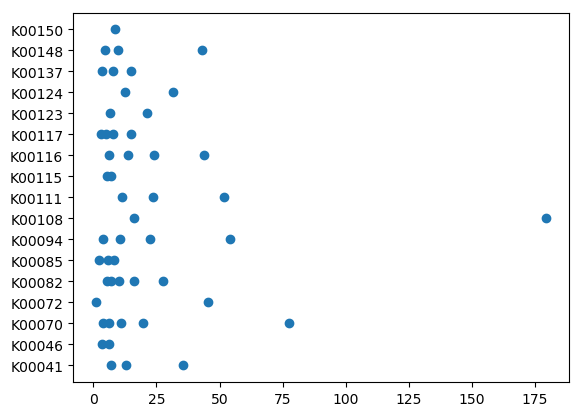

PyObject <matplotlib.collections.PathCollection object at 0x7f90c4463470>

In [62]:
using PyPlot 
scatter(CKS_data.Per[1:50],CKS_data[!, "KOI-S"][1:50])

In [63]:
for i = 1:len(MTS_data.KOI)
    MTS_data.KOI

939-element Vector{Float64}:
    5.01
    5.02
   46.01
   46.02
   72.01
   72.02
   89.01
   89.02
  108.01
  108.02
  112.02
  112.01
  119.01
    ⋮
 1364.01
 1589.04
 1589.01
 1589.02
 1589.03
 1589.05
  157.06
  157.01
  157.02
  157.03
  157.04
  157.05

In [38]:
cks.Delta

LoadError: type Tuple has no field Delta

In [261]:
using PyCall
lk=pyimport("lightkurve")
search_result = lk.search_lightcurve("Kepler-36", author="Kepler")
lc_collection=search_result.download_all()

LoadError: PyError (PyImport_ImportModule

The Python package lightkurve could not be imported by pyimport. Usually this means
that you did not install lightkurve in the Python version being used by PyCall.

PyCall is currently configured to use the Julia-specific Python distribution
installed by the Conda.jl package.  To install the lightkurve module, you can
use `pyimport_conda("lightkurve", PKG)`, where PKG is the Anaconda
package that contains the module lightkurve, or alternatively you can use the
Conda package directly (via `using Conda` followed by `Conda.add` etcetera).

Alternatively, if you want to use a different Python distribution on your
system, such as a system-wide Python (as opposed to the Julia-specific Python),
you can re-configure PyCall with that Python.   As explained in the PyCall
documentation, set ENV["PYTHON"] to the path/name of the python executable
you want to use, run Pkg.build("PyCall"), and re-launch Julia.

) <class 'ModuleNotFoundError'>
ModuleNotFoundError("No module named 'lightkurve'")
